In [1]:
from poke.poke_math import np
from poke.poke_core import Rayfront
import poke.plotting as plot
from poke.writing import read_serial_to_rayfront

# Generating a Jones Pupil and propagating it with HCIPy & Poppy

In this example we will start with the computation of the ELT. Then we will use HCIPy and POPPY to propagate to the image plane. First we load the TMT Rayfront that's been previously generated.

In [24]:
# Initialize a Raybundle
nrays = 128
n1 = 1
n2 = 1.0194 - 1j*6.6388 # Al in v band
radius = 1.2
ffov = 0.08
wlen = 551e-9

pth_to_tmt = '/Users/jashcraft/Desktop/poke/examples/tmt_rayfront_HeNe_256rays.msgpack'
rf = read_serial_to_rayfront(pth_to_tmt)


In [25]:
# the surface data can be seen with the surfaces attribute
rf.surfaces

[{'coating': (0.4+7j), 'surf': 2, 'mode': 'reflect'},
 {'coating': (0.4+7j), 'surf': 3, 'mode': 'reflect'},
 {'coating': (0.4+7j), 'surf': 5, 'mode': 'reflect'}]

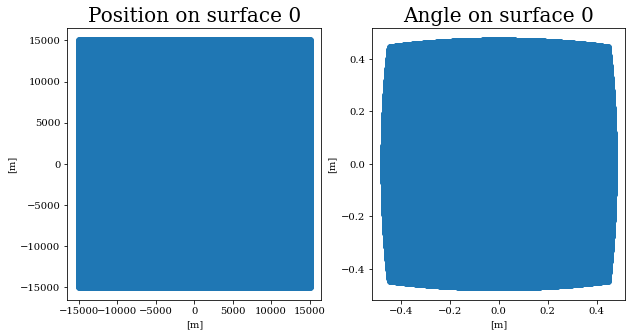

In [26]:
# We can use this method to plot the rays at a surface, which returns the position and angle
rf.PlotRaysAtSurface(surf=0)

## Now Let's Compute a Jones Pupil using our data from above

What we are doing here is a transformation from the PRT matrix (in global coordinates) to the Jones matrix (in local coordinates). This requires two vectors.
- _aloc_: which is the direction the optical axis is pointing in global coordinates
- _exit_x_: which direction will be the local x-axis after the transformation

In [27]:
# Compute the Jones Pupil from the ZOS raytrace and coating data
rf.compute_jones_pupil(aloc=np.array([0.,1.,0.]),
                       exit_x=np.array([1.,0.,0.]))

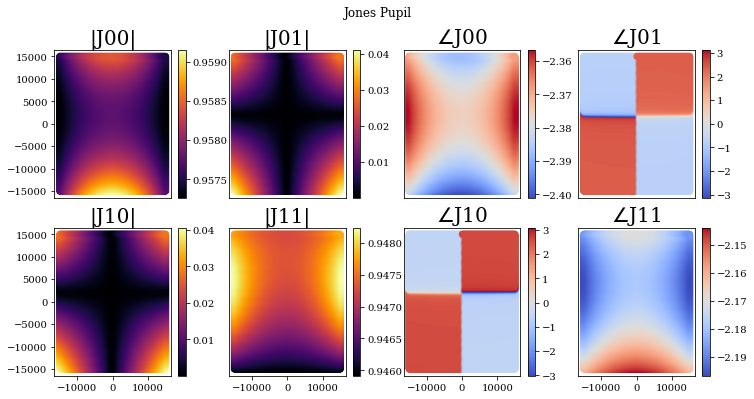

In [28]:
plot.jones_pupil(rf)

Excellent, now we have a full description of the polarization-dependent transformation our optical system imposes on an incoming field! Now, let's use our favorite diffraction propagators to compute a PSF!

## HCIPy
HICPy is the only open-source high-contrast imaging simulator (to my knowledge) to have modules for polarization so we will be using one of them to compute the PSF of a generally polarized wavefront following this example [this example](https://docs.hcipy.org/0.3.1/tutorials/PolarizationIntro/PolarizationIntro.html) with some small modifications. First we need to convert the jones pupil to an HCIPy Wavefront.

In [111]:
from hcipy import *
import poke.interfaces
from poke.interfaces import jones_pupil_to_hcipy_wavefront
import matplotlib.pyplot as plt
from importlib import reload
reload(poke.interfaces)

<module 'poke.interfaces' from '/Users/jashcraft/Desktop/poke/poke/interfaces.py'>

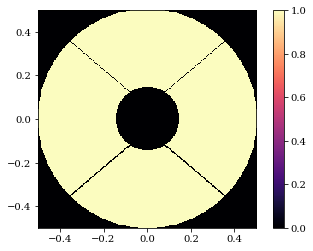

In [83]:
pupil_grid = make_pupil_grid(256)
aperture = make_magellan_aperture(True)(pupil_grid)

plt.figure()
imshow_field(aperture)
plt.colorbar()
plt.show()

Now we can grab the jones pupil from poke and call `jones_pupil_to_hcipy_wavefront` to make it a partially  polarized wavefront. Below we plot the intensity across the exit pupil of the TMT and apply the magellan aperture to it.

<ipython-input-93-cb5487bf7f82>:5: RuntimeWarning: invalid value encountered in divide
  imshow_field(partially_polarized_wavefront.intensity/aperture)


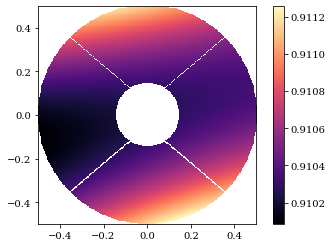

In [93]:
# Now get the jones pupil
partially_polarized_wavefront = jones_pupil_to_hcipy_wavefront(rf.jones_pupil,pupil_grid,shape=256,input_stokes_vector=[1, 0.3, -0.2, 0.1])
partially_polarized_wavefront.electric_field *= aperture # apply the magellan aperture
plt.figure()
imshow_field(partially_polarized_wavefront.intensity/aperture)
plt.colorbar()
plt.show()

In [94]:
def imshow_stokes_vector(wavefront):
    I_max = wavefront.I.max()

    plt.subplot(2, 2, 1)
    plt.title('I')
    imshow_field(wavefront.I, cmap='inferno')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.title('Q')
    imshow_field(wavefront.Q, cmap='RdBu', vmin=-I_max, vmax=I_max)
    plt.colorbar()

    plt.subplot(2, 2, 3)
    plt.title('U')
    imshow_field(wavefront.U, cmap='RdBu', vmin=-I_max, vmax=I_max)
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.title('V')
    imshow_field(wavefront.V, cmap='RdBu', vmin=-I_max, vmax=I_max)
    plt.colorbar()


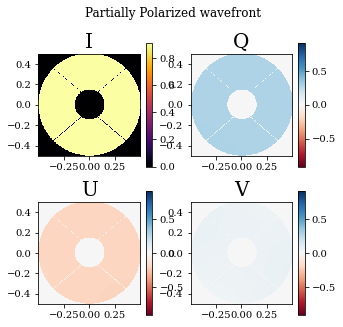

In [95]:
plt.figure(figsize=[5,5])
plt.suptitle('Partially Polarized wavefront')
imshow_stokes_vector(partially_polarized_wavefront)
plt.show()

## Time to send the wavefront through the Fraunhofer Propagator

In [96]:
focal_grid = make_focal_grid(8, 8)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
partially_polarized_image = prop(partially_polarized_wavefront)

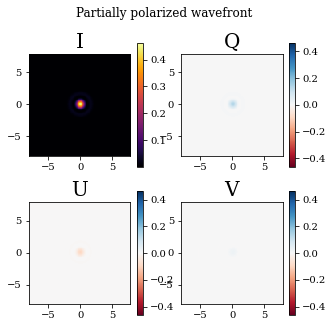

In [97]:
plt.figure(figsize=[5,5])
plt.suptitle('Partially polarized wavefront')
imshow_stokes_vector(partially_polarized_image)
plt.show()

## Now Pass this data through a linear polarizing beam splitter

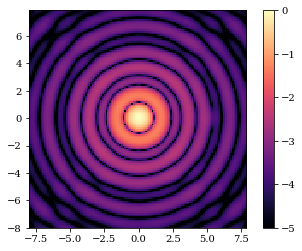

In [100]:
# Unpolarized Star
stokes_vector_planet = [1, 0.1, 0, 0]
contrast = 3e-4
angular_separation = 5 # lambda / D
num_photons_star = 1e9

wf_star = Wavefront(aperture)
wf_star.total_power = num_photons_star
jones_matrix = partially_polarized_wavefront.electric_field

e_planet = aperture * np.exp(2j * np.pi * pupil_grid.x * angular_separation)
wf_planet = Wavefront(jones_matrix*e_planet, input_stokes_vector=stokes_vector_planet)
wf_planet.total_power = num_photons_star * contrast

# Calculate science image for the star and planet
science_image = prop(wf_star).power
science_image += prop(wf_planet).power

# Simulate photon noise
science_image = large_poisson(science_image)

imshow_field(np.log10(science_image / science_image.max() + 1e-20), vmin=-5, vmax=0)
plt.colorbar()
plt.show()

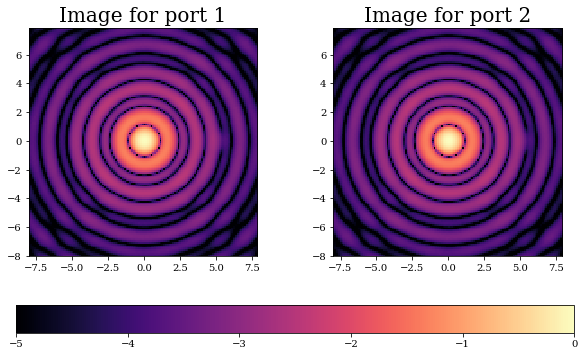

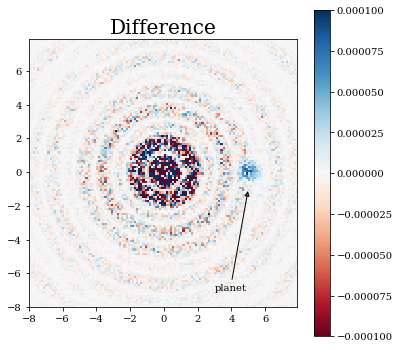

In [101]:
pbs = LinearPolarizingBeamSplitter(0)

img_star_1, img_star_2 = pbs(prop(wf_star))
img_planet_1, img_planet_2 = pbs(prop(wf_planet))

science_image_1 = img_star_1.power + img_planet_1.power
science_image_2 = img_star_2.power + img_planet_2.power

science_image_1 = large_poisson(science_image_1)
science_image_2 = large_poisson(science_image_2)

fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2)

axes[0].set_title('Image for port 1')
imshow_field(np.log10(science_image_1 / science_image_1.max() + 1e-20), vmin=-5, vmax=0, ax=axes[0])

axes[1].set_title('Image for port 2')
imshow_field(np.log10(science_image_2 / science_image_2.max() + 1e-20), vmin=-5, vmax=0, ax=axes[1])

plt.colorbar(ax=axes.tolist(), orientation="horizontal")
plt.show()

plt.figure(figsize=[6,6])
plt.title('Difference')
imshow_field((science_image_1 - science_image_2) / science_image_1.max(), cmap='RdBu',vmin=-1e-4,vmax=1e-4)
plt.annotate('planet', xy=(5, -1), xytext=(3, -7), arrowprops={'arrowstyle': '-|>'})
plt.colorbar()
plt.show()

## POPPY
Poppy requires a good deal of hand-holding re: polarization because it doesn't support polarized propagation (yet!). But we can leverage what we know about the electric field to compute a simmilar result! 

Diffraction simulation can be performed by treating the elements of the jones pupil as individual wavefronts. We can do this because jones matrices are simply the complex amplitude coefficients of a scalar field for 4 different polarization states:
- x polarization that stays x polarized
- x polarization that rotates into y polarization
- y polarization that rotates into x polarization
- y polarization that stays y polarized

So, each field is valid for propagation through a POPPY optical system. Let's start with setting up a `poppy.OpticalSystem` that focuses the jones wavefronts after a magellan aperture.

In [102]:
import poppy
import astropy.units as u

In [112]:
def focus_magellan(wflist):
    # assumes an unpolarized signal
    psfs = []
    osys = poppy.OpticalSystem(pupil_diameter=1*u.m,npix=256,oversample=1)
    osys.add_pupil(poppy.AsymmetricSecondaryObscuration(secondary_radius=0.1*u.m,
                                             support_angle=(40, 140, 220, 320),
                                             support_width=[0.03, 0.03, 0.03, 0.03],
                                             support_offset_x=[0, 0, 0, 0],
                                             name='Complex secondary'))
    osys.add_pupil(poppy.CircularAperture(radius=0.5*u.m))
    osys.add_detector(pixelscale=0.01, fov_arcsec=4.0)

    for wf in wflist:
        psfs.append(osys.propagate(wf))

    return psfs


Next we use the poppy interface to return a list of 4 wavefronts. They return in the order Jxx, Jxy, Jyx, Jyy. 

In [120]:
from poke.interfaces import jones_pupil_to_poppy_wavefronts

wflist = jones_pupil_to_poppy_wavefronts(rf.jones_pupil,wavelength=633e-9)
psfs = focus_magellan(wflist)

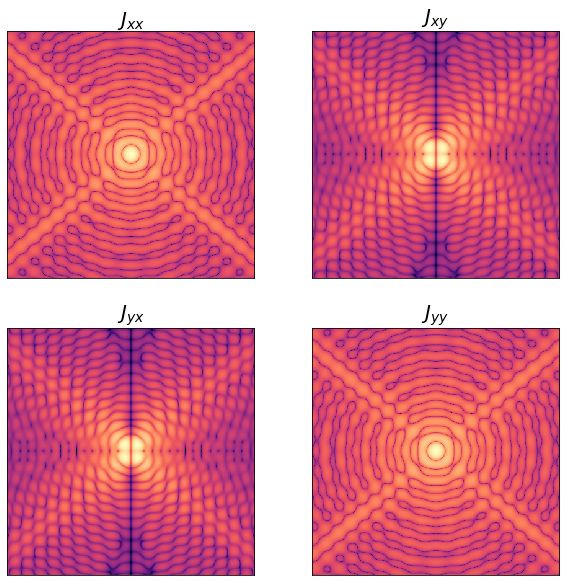

In [129]:
# now we plot it
titles = [r'$J_{xx}$',r'$J_{xy}$',r'$J_{yx}$',r'$J_{yy}$']
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=[10,10])
for i,(psf,ax,title) in enumerate(zip(psfs,axs.ravel(),titles)):
    ax.set_title(title)
    ax.imshow(np.log10(psf.intensity))
    ax.set_xticks([])
    ax.set_yticks([])

These wavefronts can be individually propagated through any poppy optical system for analysis of polarization and diffraction. The response to an unpolarized source is equal to the sum of the intensities of the four fields, but if there is polarization in the source it get's a litte more tricky. We will save that investigation for another demo